# Train Bandits with per-arm features

**Exploring linear and nonlinear** (e.g., those with neural network-based value functions) bandit methods for recommendations using TF-Agents

> Neural linear bandits provide a nice way to leverage the representation power of deep learning and the bandit approach for uncertainty measure and efficient exploration

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
PREFIX = 'mabv1'

In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "mabv1"
VERSION                  = "v1"

BUCKET_NAME              = "mabv1-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://mabv1-hybrid-vertex-bucket/data"
BUCKET_URI               = "gs://mabv1-hybrid-vertex-bucket"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid-vertex.movielens_dataset_mabv1"
BIGQUERY_TABLE_ID        = "hybrid-vertex.movielens_dataset_mabv1.training_dataset"

REPO_DOCKER_PATH_PREFIX  = "src"
RL_SUB_DIR               = "per_arm_rl"



## imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
# from tf_agents.agents import TFAgent

# from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
# from tf_agents.drivers import dynamic_step_driver
# from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

# from tf_agents.bandits.agents import lin_ucb_agent
# from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.bandits.policies import policy_utilities

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [5]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
    
# gpus

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [8]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### Read TF Records

In [9]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [10]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://mabv1-hybrid-vertex-bucket/data/train/ml-ratings-100k-train.tfrecord']

In [11]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'898'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([885409515])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'681'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'marketing'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


### get vocab

**TODO:** 
* streamline vocab calls

In [12]:
GENERATE_VOCABS = False
print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

VOCAB_SUBDIR   = "vocabs"
VOCAB_FILENAME = "vocab_dict.pkl"

GENERATE_VOCABS: False


In [13]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    vocab_dict = pkl.load(filehandler)
    filehandler.close()
    
    for key in vocab_dict.keys():
        pprint(key)

Downloaded vocab from: gs://mabv1-hybrid-vertex-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


## helper functions

**TODO:**
* modularize in a train_utils or similar

In [14]:
def _add_outer_dimension(x):
    """Adds an extra outer dimension."""
    if isinstance(x, dict):
        for key, value in x.items():
            x[key] = tf.expand_dims(value, 1)
        return x
    return tf.expand_dims(x, 1)

# Multi-Armed Bandits with Per-Arm Features

In [15]:
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer

nest = tf.nest

## Preprocessing layers for global and arm features

The preproccesing layers will ultimately feed the two functions described below, both of which will ultimately feed the `Environment`

`global_context_sampling_fn`: 
* A function that outputs a random 1d array or list of ints or floats
* This output is the global context. Its shape and type must be consistent across calls.

`arm_context_sampling_fn`: 
* A function that outputs a random 1 array or list of ints or floats (same type as the output of `global_context_sampling_fn`). * This output is the per-arm context. Its shape must be consistent across calls.

In [105]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 16
MV_EMBEDDING_SIZE      = 32 #32

### global context (user) features

#### user ID

In [106]:
user_id_input_layer = tf.keras.Input(
    name="user_id",
    shape=(1,),
    dtype=tf.string
)

user_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_id'],
)(user_id_input_layer)

user_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_id_lookup)

user_id_embedding = tf.reduce_sum(user_id_embedding, axis=-2)

# global_inputs.append(user_id_input_layer)
# global_features.append(user_id_embedding)

In [107]:
test_user_id_model = tf.keras.Model(inputs=user_id_input_layer, outputs=user_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_id"])
    print(test_user_id_model(x["user_id"]))

tf.Tensor([b'681'], shape=(1,), dtype=string)
tf.Tensor(
[[-0.01237053  0.04272605  0.03899509  0.01005216  0.02764424  0.01830009
   0.00785178 -0.01871095 -0.01187667  0.02016312 -0.01787934 -0.04571611
   0.00920055  0.03429801  0.00375974 -0.04403113]], shape=(1, 16), dtype=float32)


#### user AGE

In [108]:
user_age_input_layer = tf.keras.Input(
    name="bucketized_user_age",
    shape=(1,),
    dtype=tf.float32
)

user_age_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['bucketized_user_age'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(user_age_input_layer)

user_age_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['bucketized_user_age']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_age_lookup)

user_age_embedding = tf.reduce_sum(user_age_embedding, axis=-2)

# global_inputs.append(user_age_input_layer)
# global_features.append(user_age_embedding)

In [109]:
test_user_age_model = tf.keras.Model(inputs=user_age_input_layer, outputs=user_age_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["bucketized_user_age"])
    print(test_user_age_model(x["bucketized_user_age"]))

tf.Tensor([35.], shape=(1,), dtype=float32)
tf.Tensor(
[[ 0.02922834 -0.03623074 -0.04356749  0.03389562  0.02028917  0.0209024
  -0.02293892 -0.00381336 -0.04403089 -0.01935632 -0.0428206   0.01129373
   0.00368338  0.04129788 -0.00825077  0.00034065]], shape=(1, 16), dtype=float32)


#### user OCC

In [110]:
user_occ_input_layer = tf.keras.Input(
    name="user_occupation_text",
    shape=(1,),
    dtype=tf.string
)

user_occ_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_occupation_text'],
)(user_occ_input_layer)

user_occ_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_occ_lookup)

user_occ_embedding = tf.reduce_sum(user_occ_embedding, axis=-2)

# global_inputs.append(user_occ_input_layer)
# global_features.append(user_occ_embedding)

In [111]:
test_user_occ_model = tf.keras.Model(inputs=user_occ_input_layer, outputs=user_occ_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_occupation_text"])
    print(test_user_occ_model(x["user_occupation_text"]))

tf.Tensor([b'marketing'], shape=(1,), dtype=string)
tf.Tensor(
[[ 0.03190381 -0.00927005 -0.04313196  0.03492564  0.02356889 -0.03312018
   0.0264529  -0.01293292  0.02644515 -0.04095269  0.00482063 -0.04584609
   0.00388694  0.04980931  0.03409917  0.0424122 ]], shape=(1, 16), dtype=float32)


#### user Timestamp

In [112]:
user_ts_input_layer = tf.keras.Input(
    name="timestamp",
    shape=(1,),
    dtype=tf.int64
)

user_ts_lookup = tf.keras.layers.Discretization(
    vocab_dict['timestamp_buckets'].tolist()
)(user_ts_input_layer)

user_ts_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['timestamp_buckets'].tolist()) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_ts_lookup)

user_ts_embedding = tf.reduce_sum(user_ts_embedding, axis=-2)

# global_inputs.append(user_ts_input_layer)
# global_features.append(user_ts_embedding)

In [113]:
test_user_ts_model = tf.keras.Model(inputs=user_ts_input_layer, outputs=user_ts_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["timestamp"])
    print(test_user_ts_model(x["timestamp"]))

tf.Tensor([885409515], shape=(1,), dtype=int64)
tf.Tensor(
[[ 0.04634554  0.02952758  0.00446534 -0.02251214 -0.00354333  0.02966965
   0.0066591   0.04809007 -0.00622239  0.03113474  0.02514498  0.03049136
   0.02070678  0.04928255  0.01275302  0.04302807]], shape=(1, 16), dtype=float32)


#### define global sampling function

In [114]:
def _get_global_context_features(x):
    """
    This function generates a single global observation vector.
    """
    user_id_value = x['user_id']
    user_age_value = x['bucketized_user_age']
    user_occ_value = x['user_occupation_text']
    user_ts_value = x['timestamp']

    _id = test_user_id_model(user_id_value) # input_tensor=tf.Tensor(shape=(4,), dtype=float32)
    _age = test_user_age_model(user_age_value)
    _occ = test_user_occ_model(user_occ_value)
    _ts = test_user_ts_model(user_ts_value)

    # # tmp - insepct numpy() values
    # print(_id.numpy()) #[0])
    # print(_age.numpy()) #[0])
    # print(_occ.numpy()) #[0])
    # print(_ts.numpy()) #[0])

    # to numpy array
    _id = np.array(_id.numpy())
    _age = np.array(_age.numpy())
    _occ = np.array(_occ.numpy())
    _ts = np.array(_ts.numpy())

    concat = np.concatenate(
        [_id, _age, _occ, _ts], axis=-1 # -1
    ).astype(np.float32)

    return concat

In [115]:
for epoch in range(1):
    
    iterator = iter(train_dataset.batch(5))
    data = next(iterator)

data

{'bucketized_user_age': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([35., 18., 56., 45., 35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
 array([[7],
        [4],
        [9],
        [4],
        [7]])>,
 'movie_id': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'898', b'367', b'484', b'494', b'58'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([885409515, 883388887, 891249586, 878044851, 880130613])>,
 'user_id': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'681', b'442', b'932', b'506', b'18'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'marketing', b'student', b'educator', b'programmer', b'other'],
       dtype=object)>,
 'user_rating': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([4., 2., 5., 5., 4.], dtype=float32)>}

In [116]:
GLOBAL_DIM = _get_global_context_features(data).shape[1]
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

GLOBAL_DIM: 64


### arm preprocessing layers

#### movie ID

In [117]:
mv_id_input_layer = tf.keras.Input(
    name="movie_id",
    shape=(1,),
    dtype=tf.string
)

mv_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['movie_id'],
)(mv_id_input_layer)

mv_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_id_lookup)

mv_id_embedding = tf.reduce_sum(mv_id_embedding, axis=-2)

# arm_inputs.append(mv_id_input_layer)
# arm_features.append(mv_id_embedding)

In [118]:
test_mv_id_model = tf.keras.Model(inputs=mv_id_input_layer, outputs=mv_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_id"])
    print(test_mv_id_model(x["movie_id"]))

tf.Tensor([b'898'], shape=(1,), dtype=string)
tf.Tensor(
[[-0.00041752  0.0436858   0.02494292  0.00602082 -0.0181487   0.01706449
   0.04150244 -0.00970482 -0.04617732  0.02255699  0.02776474  0.04368807
  -0.03343403 -0.03742895  0.00868342 -0.04441062 -0.00337343  0.02771598
   0.02233488  0.00662117 -0.04954821  0.00578884 -0.02562299 -0.01392646
  -0.02248575 -0.03716139 -0.00034835 -0.00115373 -0.02403097  0.01726297
  -0.0194939  -0.01918949]], shape=(1, 32), dtype=float32)


#### movie genre

In [119]:
mv_genre_input_layer = tf.keras.Input(
    name="movie_genres",
    shape=(1,),
    dtype=tf.float32
)

mv_genre_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_genres'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(mv_genre_input_layer)

mv_genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_genres']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_genre_lookup)

mv_genre_embedding = tf.reduce_sum(mv_genre_embedding, axis=-2)

# arm_inputs.append(mv_genre_input_layer)
# arm_features.append(mv_genre_embedding)

In [120]:
test_mv_gen_model = tf.keras.Model(inputs=mv_genre_input_layer, outputs=mv_genre_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_genres"])
    print(test_mv_gen_model(x["movie_genres"]))

tf.Tensor([[7]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[ 0.0195425  -0.03508804 -0.04858688 -0.0302384  -0.03793366  0.00176525
   0.0087137  -0.00820142  0.04043672 -0.02106048  0.04328927  0.02527058
   0.04626379 -0.00862777  0.03132896  0.03828596  0.00950456  0.01126551
   0.04042298  0.01200523 -0.00978797  0.04150338 -0.04806037  0.03919048
   0.04467103  0.04553734 -0.01357924  0.00325252 -0.00754118 -0.00546048
  -0.00988909  0.04442132]], shape=(1, 32), dtype=float32)


#### define sampling function

In [121]:
def _get_per_arm_features(x):
    """
    This function generates a single per-arm observation vector
    """
    mv_id_value = x['movie_id']
    mv_gen_value = x['movie_genres']

    _mid = test_mv_id_model(mv_id_value)
    _mgen = test_mv_gen_model(mv_gen_value)

    # to numpy array
    _mid = np.array(_mid.numpy())
    _mgen = np.array(_mgen.numpy())

    # print(_mid)
    # print(_mgen)

    concat = np.concatenate(
        [_mid, _mgen], axis=-1 # -1
    ).astype(np.float32)
    # concat = tf.concat([_mid, _mgen], axis=-1).astype(np.float32)

    return concat #this is special to this example - there is only one action dimensions

In [122]:
_get_per_arm_features(data).shape #shape checks out at batchdim, nactions, arm feats

(5, 64)

In [123]:
PER_ARM_DIM = _get_per_arm_features(data).shape[1]
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

PER_ARM_DIM: 64


## TF-Agents implementation

In TF-Agents, the *per-arm features* implementation differs from the *global-only* feature examples in the following aspects:
* Reward is modeled not per-arm, but globally.
* The arms are permutation invariant: it doesn’t matter which arm is arm 1 or arm 2, only their features.
* One can have a different number of arms to choose from in every step (note that unspecified/dynamically changing number of arms will have a problem with XLA compatibility).

When implementing per-arm features in TF-Bandits, the following details have to be discussed:
* Observation spec and observations,
* Action spec and actions,
* Implementation of specific policies and agents.


**TODO:**
* outline the components and highlight their interactions, dependencies on eachother, etc.

In [124]:
BATCH_SIZE  = 8
NUM_ACTIONS = 2 #this is kinda deceptive - 
#our approach is to learn by "flashing" one movie rating at a time per user context. 
#The n_actions = show/don't show the movie with one degree of freedom (n-1)

# GLOBAL_DIM = 16
# PER_ARM_DIM = 16

print(f"BATCH_SIZE  : {BATCH_SIZE}")
print(f"NUM_ACTIONS : {NUM_ACTIONS}")
print(f"GLOBAL_DIM  : {GLOBAL_DIM}")
print(f"PER_ARM_DIM : {PER_ARM_DIM}")

BATCH_SIZE  : 8
NUM_ACTIONS : 2
GLOBAL_DIM  : 64
PER_ARM_DIM : 64


## Tensor Specs

**TODO:**
* explain relationship between Tensor Specs and their Tensor counterparts
* highlight the errors, lessons learned, and utility functions to address these

### Observation spec

**This observation spec allows the user to have a global observation of fixed dimension**, and an unspecified number of *per-arm* features (also of fixed dimension)
* The actions output by the policy are still integers as usual, and they indicate which row of the arm-features it has chosen 
* The action spec must be a single integer value without boundaries:

```python
global_spec = tensor_spec.TensorSpec([GLOBAL_DIM], tf.float32)
per_arm_spec = tensor_spec.TensorSpec([None, PER_ARM_DIM], tf.float32)
observation_spec = {'global': global_spec, 'per_arm': per_arm_spec}

action_spec = tensor_spec.TensorSpec((), tf.int32)
```
> Here the only difference compared to the action spec with global features only is that the tensor spec is not bounded, as we don’t know how many arms there will be at any time step

**XLA compatibility:**
* Since dynamic tensor shapes are not compatible with XLA, the number of arm features (and consequently, number of arms for a step) cannot be dynamic. 
* One workaround is to fix the maximum number of arms for a problem, then pad the arm features in steps with fewer arms, and use action masking to indicate how many arms are actually active.

```python
per_arm_spec = tensor_spec.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32)

action_spec = tensor_spec.BoundedTensorSpec(
    shape=(), dtype=tf.int32, minimum = 0, maximum = NUM_ACTIONS - 1
)
```

In [125]:
# # TF-Agents has many helper and utility functions
# observation_spec = bandit_spec_utils.create_per_arm_observation_spec(
#     GLOBAL_DIM, PER_ARM_DIM, NUM_ACTIONS, 
#     add_num_actions_feature=False
# ) # 2,3,4

observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}
observation_spec

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

### Action spec

> The time_step_spec and action_spec are specifications for the input time step and the output action

```python
    if (
        not tensor_spec.is_bounded(action_spec)
        or not tensor_spec.is_discrete(action_spec)
        or action_spec.shape.rank > 1
        or action_spec.shape.num_elements() != 1
    ):
      raise NotImplementedError(
          'action_spec must be a BoundedTensorSpec of type int32 and shape (). '
          'Found {}.'.format(action_spec)
      )
```

* [src](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_base_policy.py#L97)

In [126]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1, #n degrees of freedom and will dictate the expected mean reward spec shape
    name="action_spec"
)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

In [127]:
expected_num_actions = action_spec.maximum - action_spec.minimum + 1
print(f"expected_num_actions: {expected_num_actions}")

predicted_rewards_mean = tensor_spec.TensorSpec([expected_num_actions])
print(f"predicted_rewards_mean: {predicted_rewards_mean}")

expected_num_actions: 2
predicted_rewards_mean: TensorSpec(shape=(2,), dtype=tf.float32, name=None)


### TimeStep spec

In [128]:
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

### Inspect chosen arm features spec

In [129]:
time_step_spec.observation

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

In [130]:
chosen_arm_features_info = (
  policy_utilities.create_chosen_arm_features_info_spec(
      time_step_spec.observation,
  )
)
chosen_arm_features_info

TensorSpec(shape=(64,), dtype=tf.float32, name=None)

In [131]:
# TODO - dont understand this
bandit_policy_type = (
    policy_utilities.create_bandit_policy_type_tensor_spec(shape=[1])
)
bandit_policy_type

BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32))

In [132]:
info_spec = policy_utilities.PerArmPolicyInfo(
  predicted_rewards_mean=predicted_rewards_mean,
  bandit_policy_type=bandit_policy_type,
  chosen_arm_features=chosen_arm_features_info,
)
info_spec

PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None))

## The Agent

**Note** that contextual bandits form a special case of RL, where the actions taken by the agent do not alter the state of the environment 

> “Contextual” refers to the fact that the agent chooses among a set of actions while having knowledge of the context (environment observation)

### Agent types

**Possible Agent Types:**

```
AGENT_TYPE = ['LinUCB', 'LinTS', 'epsGreedy', 'NeuralLinUCB']
```

**LinearUCBAgent:** (`LinUCB`)
* An agent implementing the Linear UCB bandit algorithm
* (whitepaper) [A contextual bandit approach to personalized news recommendation](https://arxiv.org/abs/1003.0146)
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent/LinearUCBAgent)

**LinearThompsonSamplingAgent:** (`LinTS`)
* Implements the Linear Thompson Sampling Agent from the paper: [Thompson Sampling for Contextual Bandits with Linear Payoffs](https://arxiv.org/abs/1209.3352)
* the agent maintains two parameters `weight_covariances` and `parameter_estimators`, and updates them based on experience.
* The inverse of the weight covariance parameters are updated with the outer product of the observations using the Woodbury inverse matrix update, while the parameter estimators are updated by the reward-weighted observation vectors for every action
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/linear_thompson_sampling_agent/LinearThompsonSamplingAgent)

**NeuralEpsilonGreedyAgent:** (`epsGreedy`) 
* A neural network based epsilon greedy agent
* This agent receives a neural network that it trains to predict rewards
* The action is chosen greedily with respect to the prediction with probability `1 - epsilon`, and uniformly randomly with probability epsilon
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_epsilon_greedy_agent/NeuralEpsilonGreedyAgent)

**NeuralLinUCBAgent:** (`NeuralLinUCB`)
* An agent implementing the LinUCB algorithm on top of a neural network
* `ENCODING_DIM` is the output dimension of the encoding network 
> * This output will be used by either a linear reward layer and epsilon greedy exploration, or by a LinUCB logic, depending on the number of training steps executed so far
* `EPS_PHASE_STEPS` is the number training steps to run for training the encoding network before switching to `LinUCB`
> * If negative, the encoding network is assumed to be already trained
> * If the number of steps is less than or equal to `EPS_PHASE_STEPS`, `epsilon greedy` is used, otherwise `LinUCB`
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_linucb_agent/NeuralLinUCBAgent)

### network types

Which network architecture to use for the `epsGreedy` or `NeuralLinUCB` agents

```
NETWORK_TYPE = ['commontower', 'dotproduct']
```

**GlobalAndArmCommonTowerNetwork:** (`commontower`)
* This network takes the output of the global and per-arm networks, and leads them through a common network, that in turn outputs reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
> * `COMMON_LAYERS` - Iterable of ints. Specifies the layers of the common tower
* The network produced by this function can be used either in `GreedyRewardPredictionPolicy`, or `NeuralLinUCBPolicy`
> * In the former case, the network must have `output_dim=1`, it is going to be an instance of `QNetwork`, and used in the policy as a reward prediction network
> * In the latter case, the network will be an encoding network with its output consumed by a reward layer or a `LinUCB` method. The specified `output_dim` will be the encoding dimension
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmCommonTowerNetwork)

**GlobalAndArmDotProductNetwork:** (`dotproduct`)
* This network calculates the **dot product** of the output of the global and per-arm networks and returns them as reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmDotProductNetwork)

### define agent and network

In [133]:
print(f"GLOBAL_DIM : {GLOBAL_DIM}")
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

GLOBAL_DIM : 64
PER_ARM_DIM: 64


In [134]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# ================================
# Agent's Preprocess Network
# ================================
NETWORK_TYPE    = "dotproduct" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    

GLOBAL_LAYERS   = [64, 32]
ARM_LAYERS      = [64, 32]
COMMON_LAYERS   = [32]

observation_and_action_constraint_splitter = None

HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
}
pprint(HPARAMS)

{'batch_size': 8,
 'common_layers': [32],
 'epsilon': 0.01,
 'global_layers': [64, 32],
 'learning_rate': 0.05,
 'model_type': 'epsGreedy',
 'network_type': 'dotproduct',
 'num_actions': 2,
 'per_arm_layers': [64, 32]}


### Agent Factory

**TODO:**
* consolidate agent, network, and hparams

In [135]:
print("Quick check on the inputs of the agent - this can be used to diagnose spec shape inputs")
print("\ntime_step_spec: ", time_step_spec)
print("\naction_spec: ", action_spec)
print("\nobservation_spec: ", observation_spec)

Quick check on the inputs of the agent - this can be used to diagnose spec shape inputs

time_step_spec:  TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

action_spec:  BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

observation_spec:  {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}


In [136]:
reward_spec = time_step_spec.reward
reward_spec

TensorSpec(shape=(), dtype=tf.float32, name='reward')

In [137]:
# from tf_agents.bandits.policies import policy_utilities
# from tf_agents.bandits.agents import greedy_reward_prediction_agent

# network = None
observation_and_action_constraint_splitter = None
global_step = tf.compat.v1.train.get_or_create_global_step()

def _get_agent(
    agent_type, 
    network_type, 
    time_step_spec, 
    action_spec, 
    observation_spec,
    global_step
):
    network = None

    if AGENT_TYPE == 'LinUCB':
        agent = lin_ucb_agent.LinearUCBAgent(
            time_step_spec=time_step_spec,
            action_spec=action_spec,
            alpha=AGENT_ALPHA,
            accepts_per_arm_features=True,
            dtype=tf.float32,
        )
    elif AGENT_TYPE == 'LinTS':
        agent = lin_ts_agent.LinearThompsonSamplingAgent(
            time_step_spec=time_step_spec,
            action_spec=action_spec,
            alpha=AGENT_ALPHA,
            observation_and_action_constraint_splitter=(
                observation_and_action_constraint_splitter
            ),
            accepts_per_arm_features=True,
            dtype=tf.float32,
        )
    elif AGENT_TYPE == 'epsGreedy':
        # obs_spec = per_arm_tf_env.observation_spec()
        if NETWORK_TYPE == 'commontower':
            network = global_and_arm_feature_network.create_feed_forward_common_tower_network(
                observation_spec = observation_spec, 
                global_layers = GLOBAL_LAYERS, 
                arm_layers = ARM_LAYERS, 
                common_layers = COMMON_LAYERS,
                # output_dim = 1
            )
        elif NETWORK_TYPE == 'dotproduct':
            network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
                observation_spec = observation_spec, 
                global_layers = GLOBAL_LAYERS, 
                arm_layers = ARM_LAYERS
            )
        agent = neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent(
            time_step_spec=time_step_spec,
            action_spec=action_spec,
            reward_network=network,
            optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=HPARAMS['learning_rate']),
            epsilon=HPARAMS['epsilon'],
            observation_and_action_constraint_splitter=(
                observation_and_action_constraint_splitter
            ),
            accepts_per_arm_features=True,
            emit_policy_info=(policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN),
            train_step_counter=global_step,
            # info_fields_to_inherit_from_greedy=[
            #     policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN
            # ],
            name='OffpolicyNeuralEpsGreedyAgent'
        )

    elif AGENT_TYPE == 'NeuralLinUCB':
        # obs_spec = per_arm_tf_env.observation_spec()
        network = (
            global_and_arm_feature_network.create_feed_forward_common_tower_network(
                observation_spec = observation_spec, 
                global_layers = GLOBAL_LAYERS, 
                arm_layers = ARM_LAYERS, 
                common_layers = COMMON_LAYERS,
                output_dim = ENCODING_DIM
            )
        )
        agent = neural_linucb_agent.NeuralLinUCBAgent(
            time_step_spec=per_arm_tf_env.time_step_spec(),
            action_spec=per_arm_tf_env.action_spec(),
            encoding_network=network,
            encoding_network_num_train_steps=EPS_PHASE_STEPS,
            encoding_dim=ENCODING_DIM,
            optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
            alpha=1.0,
            gamma=1.0,
            epsilon_greedy=EPSILON,
            accepts_per_arm_features=True,
            debug_summaries=True,
            summarize_grads_and_vars=True,
            emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
        )
        
    agent.initialize() # TODO - does this go here?
        
    print(f"Agent: {agent.name}\n")

    if network:
        print(f"Network: {network.name}")
        network = network.name
    
    return agent, network

In [138]:
global_step = tf.compat.v1.train.get_or_create_global_step()

agent, network = _get_agent(
    agent_type = AGENT_TYPE, 
    network_type = NETWORK_TYPE, 
    time_step_spec = time_step_spec, 
    action_spec = action_spec, 
    observation_spec = observation_spec,
    global_step = global_step
)

agent.initialize() # TODO - does this go here?

Agent: OffpolicyNeuralEpsGreedyAgent

Network: GlobalAndArmDotProductNetwork


## Reward function

**TODO:**
* explain how to translate reward to this common recommendation objectives

In [139]:
def _get_rewards(element):
    """Calculates reward for the actions."""

    def _calc_reward(x):
        """Calculates reward for a single action."""
        r0 = lambda: tf.constant(-10.0)
        r1 = lambda: tf.constant(-5.0)
        r2 = lambda: tf.constant(2.0)
        r3 = lambda: tf.constant(3.0)
        r4 = lambda: tf.constant(4.0)
        r5 = lambda: tf.constant(10.0)
        c1 = tf.equal(x, 1.0)
        c2 = tf.equal(x, 2.0)
        c3 = tf.equal(x, 3.0)
        c4 = tf.equal(x, 4.0)
        c5 = tf.equal(x, 5.0)
        return tf.case(
            [(c1, r1), (c2, r2), (c3, r3),(c4, r4),(c5, r5)], 
            default=r0, exclusive=True
        )

    return tf.map_fn(
        fn=_calc_reward, 
        elems=element['user_rating'], 
        dtype=tf.float32
    )

## Trajectory function

**parking lot**
* does trajectory fn need concept of `dummy_chosen_arm_features`, similar to [this](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_base_policy.py#L297)

```python
      dummy_chosen_arm_features = tf.nest.map_structure(
          lambda obs: tf.zeros_like(obs[:, 0, ...]),
          time_step.observation[bandit_spec_utils.PER_ARM_FEATURE_KEY],
      )
```

In [140]:
from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory

def _trajectory_fn(element): # hparams
    
    """Converts a dataset element into a trajectory."""
    global_features = _get_global_context_features(element)
    arm_features = _get_per_arm_features(element)
    
    # Adds a time dimension.
    arm_features = _add_outer_dimension(arm_features)

    # obs spec
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            _add_outer_dimension(global_features), #timedim bloat
        # bandit_spec_utils.PER_ARM_FEATURE_KEY:
        #     arm_features
    }

    reward = _add_outer_dimension(_get_rewards(element))

    # To emit the predicted rewards in policy_info, we need to create dummy
    # rewards to match the definition in TensorSpec for the ones specified in
    # emit_policy_info set.
    dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_actions']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        # Pass dummy mean rewards here to match the model_spec for emitting
        # mean rewards in policy info
        predicted_rewards_mean=dummy_rewards
    )
    
    if HPARAMS['model_type'] == 'neural_ucb':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
        
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=reward,
        discount=tf.zeros_like(reward)
    )


### Vertex Experiment

In [141]:
EXPERIMENT_NAME   = f'mab-v3'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : mab-v3
RUN_NAME          : run-20230816-032745

BASE_OUTPUT_DIR   : gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/artifacts


## Train loop

`agent.train(experience=...)`

where `experience` is a batch of trajectories data in the form of a Trajectory. 
* The structure of experience must match that of `self.training_data_spec`. 
* All tensors in experience must be shaped [batch, time, ...] where time must be equal to self.train_step_length if that property is not None.

In [142]:
global_step = tf.compat.v1.train.get_or_create_global_step()

agent, network = _get_agent(
    agent_type = AGENT_TYPE, 
    network_type = NETWORK_TYPE, 
    time_step_spec = time_step_spec, 
    action_spec = action_spec, 
    observation_spec = observation_spec,
    global_step = global_step
)

agent.initialize() # TODO - does this go here?

Agent: OffpolicyNeuralEpsGreedyAgent

Network: GlobalAndArmDotProductNetwork


In [143]:
agent.policy.trajectory_spec

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.i

In [144]:
from tf_agents.metrics import export_utils
from tf_agents.metrics import tf_metrics

agent.initialize() # TODO - does this go here?

# ====================================================
# TB summary writer
# ====================================================
logging.info(f" log_dir: {LOG_DIR}")

train_summary_writer = tf.compat.v2.summary.create_file_writer(
    LOG_DIR, flush_millis=10 * 1000
)
train_summary_writer.set_as_default()

# ====================================================
# metrics
# ====================================================
step_metric = tf_metrics.EnvironmentSteps()
metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.AverageEpisodeLengthMetric(batch_size=HPARAMS['batch_size']),
    tf_metrics.AverageReturnMetric(batch_size=HPARAMS['batch_size'])
]
# if additional_metrics:
#     metrics += additional_metrics
    
metric_results = defaultdict(list)

def _export_metrics_and_summaries(step, metrics):
    """Exports metrics and tf summaries."""
    metric_utils.log_metrics(metrics)
    export_utils.export_metrics(step=step, metrics=metrics)
    for metric in metrics:
        metric.tf_summaries(train_step=step)

In [145]:
metrics

In [146]:
# ====================================================
# checkpoint manager
# ====================================================
AGENT_CHECKPOINT_NAME = 'agent'
STEP_CHECKPOINT_NAME = 'step'
CHECKPOINT_FILE_PREFIX = 'ckpt'

def restore_and_get_checkpoint_manager(root_dir, agent, metrics, step_metric):
    """
    Restores from `root_dir` and returns a function that writes checkpoints.
    """
    trackable_objects = {metric.name: metric for metric in metrics}
    trackable_objects[AGENT_CHECKPOINT_NAME] = agent
    trackable_objects[STEP_CHECKPOINT_NAME] = step_metric
    checkpoint = tf.train.Checkpoint(**trackable_objects)
    checkpoint_manager = tf.train.CheckpointManager(
      checkpoint=checkpoint, directory=root_dir, max_to_keep=5
    )
    latest = checkpoint_manager.latest_checkpoint
    if latest is not None:
        logging.info('Restoring checkpoint from %s.', latest)
        checkpoint.restore(latest)
        logging.info('Successfully restored to step %s.', step_metric.result())
    else:
        logging.info(
            'Did not find a pre-existing checkpoint. Starting from scratch.'
        )
    return checkpoint_manager

# get checkpoint manager
CHKPOINT_DIR = f"{ROOT_DIR}/chkpoint"
print(f"setting checkpoint_manager: {CHKPOINT_DIR}")

checkpoint_manager = restore_and_get_checkpoint_manager(
    root_dir=CHKPOINT_DIR, 
    agent=agent, 
    metrics=metrics, 
    step_metric=step_metric
)

setting checkpoint_manager: gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root/chkpoint


In [87]:
# DATA_SIZE = len(list(train_dataset))
# NUM_ITER_STEPS = DATA_SIZE // HPARAMS['batch_size']

DATA_SIZE = 80000
NUM_ITER_STEPS = 10000

print(f"DATA_SIZE      : {DATA_SIZE}")
print(f"NUM_ITER_STEPS : {NUM_ITER_STEPS}")

DATA_SIZE      : 80000
NUM_ITER_STEPS : 10000


In [147]:
import collections
from tf_agents.utils import common
from tf_agents.eval import metric_utils
from tf_agents.policies import policy_saver

NUM_EPOCHS = 1000
# NUM_ITERATION_PER_LOOP = NUM_ITER_STEPS
log_interval = 100

# global_step = tf.compat.v1.train.get_global_step()

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
# agent.train = common.function(agent.train)

# Reset the train step
# agent.train_step_counter.assign(0)

train_step_counter = tf.compat.v1.train.get_or_create_global_step()
saver = policy_saver.PolicySaver(
    agent.policy, 
    train_step=train_step_counter
)
starting_loop = 0

# train_loss = collections.defaultdict(list)
list_o_loss = []

print(f"starting train loop...")
start_time = time.time()

iterator = iter(train_dataset.batch(HPARAMS['batch_size']))

for epoch in range(NUM_EPOCHS):

    # iterator = iter(train_dataset.batch(HPARAMS['batch_size']))
    data = next(iterator)
    # print(f"print data: {data}")

    trajectories = _trajectory_fn(data)
    # print(f"print trajectories: {trajectories}")

    # All tensors in experience must be shaped [batch, time, ...] 
    step = agent.train_step_counter.numpy()
    loss = agent.train(experience=trajectories)
    # agent.train(experience=trajectories)
    list_o_loss.append(loss.loss.numpy())

    _export_metrics_and_summaries(
        step=epoch, 
        metrics=metrics
    )
    
    # print 
    if log_interval and step % log_interval == 0:
        print(
            'step = {0}: loss = {1}'.format(
                step, round(loss.loss.numpy(), 2)
            )
        )
        # print(f"trajectories: {trajectories}")
        
    if epoch > 0 and epoch % 1000 == 0:
        saver.save(os.path.join(CHKPOINT_DIR, 'policy_%d' % step_metric.result()))
        print(f"saved policy to: {CHKPOINT_DIR}")
        
saver.save(ARTIFACTS_DIR)
print(f"saved trained policy to: {ARTIFACTS_DIR}")
    
runtime_mins = int((time.time() - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

starting train loop...
step = 500: loss = 45.90999984741211
step = 600: loss = 7.760000228881836
saved policy to: gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root/chkpoint
step = 700: loss = 14.90999984741211
saved policy to: gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root/chkpoint
step = 800: loss = 14.430000305175781
saved policy to: gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root/chkpoint
step = 900: loss = 26.920000076293945
saved policy to: gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root/chkpoint
step = 1000: loss = 7.110000133514404
saved policy to: gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root/chkpoint
step = 1100: loss = 12.260000228881836
saved policy to: gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root/chkpoint
step = 1200: loss = 19.670000076293945
saved policy to: gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root/chkpoint
step = 1300: loss = 9.65999984741211
saved p

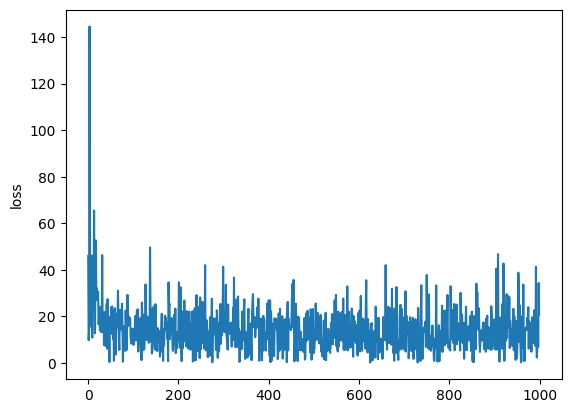

In [148]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
plt.ylabel('loss')
plt.show()

In [153]:
# list_o_loss[-1]

# TODO - evaluate trained policy on val split

20.856632

In [118]:
# %load_ext tensorboard
%reload_ext tensorboard

In [119]:
%tensorboard --logdir=$LOG_DIR

In [ ]:
# # ====================================================
# # TB summary writer
# # ====================================================
# logging.info(f" log_dir: {LOG_DIR}")

# train_summary_writer = tf.compat.v2.summary.create_file_writer(
#     LOG_DIR, flush_millis=10 * 1000
# )
# train_summary_writer.set_as_default()

# # ====================================================
# # metrics
# # ====================================================
# step_metric = tf_metrics.EnvironmentSteps()
# metrics = [
#     tf_metrics.NumberOfEpisodes(),
#     tf_metrics.AverageEpisodeLengthMetric(batch_size=HPARAMS['batch_size']),
#     tf_metrics.AverageReturnMetric(batch_size=HPARAMS['batch_size'])
# ]
# # if additional_metrics:
# #     metrics += additional_metrics
    
# metric_results = defaultdict(list)

## debugging notes

* say you have a global observation spec of [17]. And you have two batch dimensions [4, 5]. Then your observation has to have the shape [4, 5, 17]
* and then if you have arm_obs_spec with shape [9, 13], then the arm obs shape has to be exactly [4, 5, 9, 13]
* and this has to be true for every single tensor in your tensor nest
* the first 2 dims are the outer dims that are the same for all tensors, the rest of the dimensions have to follow the spec for each tensor

### testing train package

#### Vertex Experiments

In [99]:
# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : mab-v2
RUN_NAME          : run-20230815-194208

BASE_OUTPUT_DIR   : gs://mabv1-hybrid-vertex-bucket/mab-v2/run-20230815-194208
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/mab-v2/run-20230815-194208/logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/mab-v2/run-20230815-194208/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/mab-v2/run-20230815-194208/artifacts


In [100]:
global_step = tf.compat.v1.train.get_or_create_global_step()

agent, network = _get_agent(
    agent_type = AGENT_TYPE, 
    network_type = NETWORK_TYPE, 
    time_step_spec = time_step_spec, 
    action_spec = action_spec, 
    observation_spec = observation_spec,
    global_step = global_step
)

agent.initialize() # TODO - does this go here?

Agent: OffpolicyNeuralEpsGreedyAgent

Network: GlobalAndArmDotProductNetwork


In [101]:
from src.perarm_features import train_perarm_v6 as train_perarm

TRAINING_LOOPS = 500
STEPS_PER_LOOP = 1
drop_arm_feature_fn = None
ASYNC_STEPS_PER_LOOP = 1
SPLIT = "train" # "train" | "val"
agent.initialize() # TODO - does this go here?

In [102]:
#start the timer and training
start_time = time.time()

metric_results = train_perarm.train_perarm(
    agent = agent,
    num_iterations = TRAINING_LOOPS,
    steps_per_loop = STEPS_PER_LOOP,
    log_interval = 10,
    batch_size=HPARAMS['batch_size'],
    bucket_name=BUCKET_NAME,
    data_dir_prefix_path=DATA_GCS_PREFIX,
    split=SPLIT,
    _trajectory_fn = _trajectory_fn,
    # dirs
    log_dir=LOG_DIR,
    model_dir=ARTIFACTS_DIR,
    root_dir=ROOT_DIR,
    async_steps_per_loop = ASYNC_STEPS_PER_LOOP,
    resume_training_loops = False,
    # additional_metrics = metrics
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

setting checkpoint_manager: gs://mabv1-hybrid-vertex-bucket/mab-v2/run-20230815-194208/root/chkpoint
starting_loop: 0
starting train loop...
step = 0: loss = 45.97999954223633
step = 10: loss = 13.550000190734863
step = 20: loss = 8.630000114440918
step = 30: loss = 24.329999923706055
step = 40: loss = 8.180000305175781
step = 50: loss = 19.510000228881836
step = 60: loss = 7.159999847412109
step = 70: loss = 18.520000457763672
step = 80: loss = 6.980000019073486
step = 90: loss = 19.239999771118164
step = 100: loss = 9.819999694824219
saved policy to: gs://mabv1-hybrid-vertex-bucket/mab-v2/run-20230815-194208/root/chkpoint
step = 110: loss = 30.270000457763672
step = 120: loss = 18.25
step = 130: loss = 10.539999961853027
step = 140: loss = 18.459999084472656
step = 150: loss = 7.349999904632568
step = 160: loss = 4.940000057220459
step = 170: loss = 23.110000610351562
step = 180: loss = 33.689998626708984
step = 190: loss = 6.409999847412109
step = 200: loss = 16.229999542236328
save

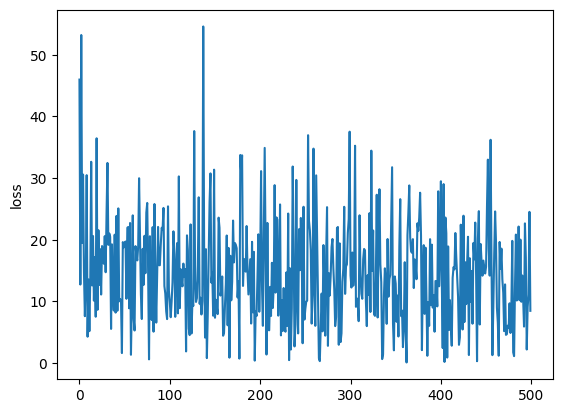

In [103]:
import matplotlib.pyplot as plt

plt.plot(metric_results)
plt.ylabel('loss')
plt.show()

In [174]:
!gsutil ls $ARTIFACTS_DIR

gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/artifacts/
gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/artifacts/fingerprint.pb
gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/artifacts/policy_specs.pbtxt
gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/artifacts/saved_model.pb
gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/artifacts/assets/
gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/artifacts/variables/


In [175]:
trained_policy = tf.saved_model.load(ARTIFACTS_DIR)
trained_policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7ff0898fda80>

In [178]:
POLICY_URI = "gs://mabv1-hybrid-vertex-bucket/mab-v3/run-20230816-032745/root/chkpoint/policy_0"
trained_policy = tf.saved_model.load(POLICY_URI)
trained_policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7ff0752901c0>

see [serving example](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/recommendation_systems/solutions/exercise_movielens_notebook.ipynb) at the bottom

In [179]:
SPLIT = "val" # "train" | "val"

val_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        val_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
val_files

['gs://mabv1-hybrid-vertex-bucket/data/val/ml-ratings-100k-val.tfrecord']

In [180]:
val_dataset = tf.data.TFRecordDataset(val_files)
val_dataset = val_dataset.map(data_utils.parse_tfrecord)

for x in val_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'211'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([874948475])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'346'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'other'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


In [181]:
for x in val_dataset.batch(1).take(1):
    eval_trajectory = _trajectory_fn(x)
    
eval_trajectory

Trajectory(
{'action': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]], dtype=int32)>,
 'discount': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]], dtype=int32)>,
 'observation': {'global': <tf.Tensor: shape=(1, 1, 64), dtype=float32, numpy=
array([[[-7.1094520e-03,  2.6941884e-02, -1.4364563e-02,  4.0817548e-02,
          1.8014226e-02, -3.5137128e-02,  4.6751175e-02,  2.5701012e-02,
         -1.7593563e-02, -1.6148351e-02, -4.4952571e-02,  2.2526216e-02,
         -2.7038550e-02, -3.2876350e-02,  2.6945736e-02, -4.8456717e-02,
         -4.8416592e-02,  5.3141229e-03, -7.5913966e-05, -4.3538954e-02,
         -9.6780546e-03,  2.5439747e-03, -4.3548133e-02,  4.9655091e-02,
          4.7168802e-02,  1.0604382e-02,  3.6899809e-02,  1.2288690e-03,
          3.8865376e-02,  5.3893924e-03,  2.3739710e-03,  1.0721795e-03,
         -3.2014750e-02,  4.3673519e-02,  1.2376793e-03, -

In [194]:
eval_trajectory.observation['global'].numpy()

array([[[-7.1094520e-03,  2.6941884e-02, -1.4364563e-02,  4.0817548e-02,
          1.8014226e-02, -3.5137128e-02,  4.6751175e-02,  2.5701012e-02,
         -1.7593563e-02, -1.6148351e-02, -4.4952571e-02,  2.2526216e-02,
         -2.7038550e-02, -3.2876350e-02,  2.6945736e-02, -4.8456717e-02,
         -4.8416592e-02,  5.3141229e-03, -7.5913966e-05, -4.3538954e-02,
         -9.6780546e-03,  2.5439747e-03, -4.3548133e-02,  4.9655091e-02,
          4.7168802e-02,  1.0604382e-02,  3.6899809e-02,  1.2288690e-03,
          3.8865376e-02,  5.3893924e-03,  2.3739710e-03,  1.0721795e-03,
         -3.2014750e-02,  4.3673519e-02,  1.2376793e-03, -4.7225453e-02,
          4.7687974e-02, -3.7321530e-02,  4.5304682e-02,  3.6678877e-02,
         -2.2708440e-02,  2.5285248e-02,  2.8502930e-02,  5.4508671e-03,
          4.0316906e-02,  8.8155381e-03,  3.0780081e-02,  4.3237321e-03,
         -7.9261549e-03,  2.9216576e-02,  4.4249240e-02,  3.8463201e-02,
         -7.7614933e-04,  2.5819134e-02, -3.7133217

In [196]:
## Inference
feature = eval_trajectory.observation['global'].numpy()
infer_step = ts.TimeStep(
        tf.constant(
            ts.StepType.FIRST, dtype=tf.int32, shape=[1],
            name='step_type'),
        tf.constant(0.0, dtype=tf.float32, shape=[1], name='reward'),
        tf.constant(1.0, dtype=tf.float32, shape=[1], name='discount'),
        tf.constant(feature,
                    dtype=tf.float64, shape=[1, 64],
                    name='observation')
)
infer_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 64), dtype=float64, numpy=
array([[-7.10945204e-03,  2.69418843e-02, -1.43645629e-02,
         4.08175476e-02,  1.80142261e-02, -3.51371281e-02,
         4.67511751e-02,  2.57010125e-02, -1.75935626e-02,
        -1.61483511e-02, -4.49525714e-02,  2.25262158e-02,
        -2.70385500e-02, -3.28763500e-02,  2.69457363e-02,
        -4.84567173e-02, -4.84165922e-02,  5.31412289e-03,
        -7.59139657e-05, -4.35389541e-02, -9.67805460e-03,
         2.54397467e-03, -4.35481332e-02,  4.96550910e-02,
         4.71688025e-02,  1.06043816e-02,  3.68998088e-02,
         1.22886896e-03,  3.88653763e-02,  5.38939238e-03,
         2.37397105e-03,  1.07217953e-03, -3.20147499e-02,
         4.36735190e-02,  1.23767927e-03, -4.72254530e-02,
         4.76879738e-02, -3.73215303e-02,  4.53046821e-02,
         3.66788767e-02, -2.27084402e-02,  2.52852477e-02,
         2.8

In [197]:
trained_policy.action(infer_step).action.numpy()

ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (2 total):
    * TimeStep(
{'discount': <tf.Tensor 'time_step_2:0' shape=(1,) dtype=float32>,
 'observation': <tf.Tensor 'time_step_3:0' shape=(1, 64) dtype=float64>,
 'reward': <tf.Tensor 'time_step_1:0' shape=(1,) dtype=float32>,
 'step_type': <tf.Tensor 'time_step:0' shape=(1,) dtype=int32>})
    * ()
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (2 total):
    * TimeStep(step_type=TensorSpec(shape=(None,), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(None,), dtype=tf.float32, name='reward'), discount=TensorSpec(shape=(None,), dtype=tf.float32, name='discount'), observation={'global': TensorSpec(shape=(None, 64), dtype=tf.float32, name='observation/global'), 'per_arm': TensorSpec(shape=(None, 2, 64), dtype=tf.float32, name='observation/per_arm')})
    * ()
  Keyword arguments: {}

Option 2:
  Positional arguments (2 total):
    * TimeStep(step_type=TensorSpec(shape=(None,), dtype=tf.int32, name='time_step_step_type'), reward=TensorSpec(shape=(None,), dtype=tf.float32, name='time_step_reward'), discount=TensorSpec(shape=(None,), dtype=tf.float32, name='time_step_discount'), observation={'global': TensorSpec(shape=(None, 64), dtype=tf.float32, name='time_step_observation_global'), 'per_arm': TensorSpec(shape=(None, 2, 64), dtype=tf.float32, name='time_step_observation_per_arm')})
    * ()
  Keyword arguments: {}

In [183]:
batch_size = len(eval_trajectory.observation)
print(f"batch_size: {batch_size}")

batch_size: 1


In [184]:
import tf_agents

time_step = tf_agents.trajectories.restart(
    observation=eval_trajectory.observation,
    batch_size=tf.convert_to_tensor([batch_size])
)
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': {'global': <tf.Tensor: shape=(1, 1, 64), dtype=float32, numpy=
array([[[-7.1094520e-03,  2.6941884e-02, -1.4364563e-02,  4.0817548e-02,
          1.8014226e-02, -3.5137128e-02,  4.6751175e-02,  2.5701012e-02,
         -1.7593563e-02, -1.6148351e-02, -4.4952571e-02,  2.2526216e-02,
         -2.7038550e-02, -3.2876350e-02,  2.6945736e-02, -4.8456717e-02,
         -4.8416592e-02,  5.3141229e-03, -7.5913966e-05, -4.3538954e-02,
         -9.6780546e-03,  2.5439747e-03, -4.3548133e-02,  4.9655091e-02,
          4.7168802e-02,  1.0604382e-02,  3.6899809e-02,  1.2288690e-03,
          3.8865376e-02,  5.3893924e-03,  2.3739710e-03,  1.0721795e-03,
         -3.2014750e-02,  4.3673519e-02,  1.2376793e-03, -4.7225453e-02,
          4.7687974e-02, -3.7321530e-02,  4.5304682e-02,  3.6678877e-02,
         -2.2708440e-02,  2.5285248e-02,  2.8502930e-02,  5.4508671e-03,
          4.0316906e-

In [186]:
get_initial_state_fn = trained_policy.signatures['get_initial_state']
get_initial_state_fn

<ConcreteFunction signature_wrapper_function_with_signature(*, batch_size) at 0x7FF088551A80>

In [187]:
action_fn = trained_policy.signatures['action']
action_fn

<ConcreteFunction signature_wrapper_function_with_signature(*, arg_0_observation_global, arg_0_discount, arg_0_reward, arg_0_step_type, arg_0_observation_per_arm) at 0x7FF08859E890>

In [192]:
action_fn(eval_trajectory.observation['global'])

TypeError: Binding inputs to tf.function `signature_wrapper_function_with_signature` failed due to `too many positional arguments`. Received args: (<tf.Tensor: shape=(1, 1, 64), dtype=float32, numpy=
array([[[-7.1094520e-03,  2.6941884e-02, -1.4364563e-02,  4.0817548e-02,
          1.8014226e-02, -3.5137128e-02,  4.6751175e-02,  2.5701012e-02,
         -1.7593563e-02, -1.6148351e-02, -4.4952571e-02,  2.2526216e-02,
         -2.7038550e-02, -3.2876350e-02,  2.6945736e-02, -4.8456717e-02,
         -4.8416592e-02,  5.3141229e-03, -7.5913966e-05, -4.3538954e-02,
         -9.6780546e-03,  2.5439747e-03, -4.3548133e-02,  4.9655091e-02,
          4.7168802e-02,  1.0604382e-02,  3.6899809e-02,  1.2288690e-03,
          3.8865376e-02,  5.3893924e-03,  2.3739710e-03,  1.0721795e-03,
         -3.2014750e-02,  4.3673519e-02,  1.2376793e-03, -4.7225453e-02,
          4.7687974e-02, -3.7321530e-02,  4.5304682e-02,  3.6678877e-02,
         -2.2708440e-02,  2.5285248e-02,  2.8502930e-02,  5.4508671e-03,
          4.0316906e-02,  8.8155381e-03,  3.0780081e-02,  4.3237321e-03,
         -7.9261549e-03,  2.9216576e-02,  4.4249240e-02,  3.8463201e-02,
         -7.7614933e-04,  2.5819134e-02, -3.7133217e-02,  2.4500970e-02,
          4.9657058e-02, -9.9259615e-04,  1.5555631e-02,  2.4034988e-02,
          4.5868706e-02, -4.3788087e-02,  3.5315286e-02, -7.9321638e-03]]],
      dtype=float32)>,) and kwargs: {} for signature: (*, arg_0_discount: TensorSpec(shape=(None,), dtype=tf.float32, name='0/discount'), arg_0_observation_global: TensorSpec(shape=(None, 64), dtype=tf.float32, name='0/observation/global'), arg_0_observation_per_arm: TensorSpec(shape=(None, 2, 64), dtype=tf.float32, name='0/observation/per_arm'), arg_0_reward: TensorSpec(shape=(None,), dtype=tf.float32, name='0/reward'), arg_0_step_type: TensorSpec(shape=(None,), dtype=tf.int32, name='0/step_type')).

In [188]:
policy_state_dict = get_initial_state_fn(batch_size=batch_size)
policy_state_dict

{}

In [185]:
policy_step = trained_policy.action(time_step)
policy_step

ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (2 total):
    * TimeStep(
{'discount': <tf.Tensor 'time_step_2:0' shape=(1,) dtype=float32>,
 'observation': {'global': <tf.Tensor 'time_step_3:0' shape=(1, 1, 64) dtype=float32>},
 'reward': <tf.Tensor 'time_step_1:0' shape=(1,) dtype=float32>,
 'step_type': <tf.Tensor 'time_step:0' shape=(1,) dtype=int32>})
    * ()
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (2 total):
    * TimeStep(step_type=TensorSpec(shape=(None,), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(None,), dtype=tf.float32, name='reward'), discount=TensorSpec(shape=(None,), dtype=tf.float32, name='discount'), observation={'global': TensorSpec(shape=(None, 64), dtype=tf.float32, name='observation/global'), 'per_arm': TensorSpec(shape=(None, 2, 64), dtype=tf.float32, name='observation/per_arm')})
    * ()
  Keyword arguments: {}

Option 2:
  Positional arguments (2 total):
    * TimeStep(step_type=TensorSpec(shape=(None,), dtype=tf.int32, name='time_step_step_type'), reward=TensorSpec(shape=(None,), dtype=tf.float32, name='time_step_reward'), discount=TensorSpec(shape=(None,), dtype=tf.float32, name='time_step_discount'), observation={'global': TensorSpec(shape=(None, 64), dtype=tf.float32, name='time_step_observation_global'), 'per_arm': TensorSpec(shape=(None, 2, 64), dtype=tf.float32, name='time_step_observation_per_arm')})
    * ()
  Keyword arguments: {}

In [ ]:
# import numpy as np
# feature = np.reshape(environment._observe()[0], (1,20))
# feature.shape

In [ ]:
## Inference
step = ts.TimeStep(
        tf.constant(
            ts.StepType.FIRST, dtype=tf.int32, shape=[1],
            name='step_type'),
        tf.constant(0.0, dtype=tf.float32, shape=[1], name='reward'),
        tf.constant(1.0, dtype=tf.float32, shape=[1], name='discount'),
        tf.constant(feature,
                    dtype=tf.float64, shape=[1, 20],
                    name='observation'))

agent.policy.action(step).action.numpy()

In [ ]:
iterator = iter(train_dataset.batch(HPARAMS['batch_size']))
data = next(iterator)